In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import tqdm
import paths
import deepdish as dd
import legwork as lw
import astropy.units as u
import astropy.constants as c

from scipy.integrate import cumulative_trapezoid, trapezoid
from scipy.interpolate import interp1d

from astropy.cosmology import Planck18, z_at_value

from schwimmbad import MultiPool

In [2]:
def get_e_LIGO(e_LISA, f_LISA, m1, m2):
    e_grid_steps = 5000
    a_LISA = lw.utils.get_a_from_f_orb(f_orb=f_LISA, m_1=m1, m_2=m2)
    e_evol_grid = np.logspace(np.log10(1e-15), np.log10(e_LISA), e_grid_steps)
    a_evol_grid = lw.utils.get_a_from_ecc(e_evol_grid, lw.utils.c_0(a_i=a_LISA, ecc_i=e_LISA))
    log_a_interp = interp1d(a_evol_grid.to(u.Rsun).value, e_evol_grid)
    a_LIGO = lw.utils.get_a_from_f_orb(f_orb=10 * u.Hz, m_1=m1, m_2=m2) 
    e_LIGO = log_a_interp(a_LIGO.to(u.Rsun).value)

    return e_LIGO

def get_e_LISA(e_LIGO, f_LISA, m1, m2):
    e_grid_steps = 5000
    a_LIGO = lw.utils.get_a_from_f_orb(f_orb=10 * u.Hz, m_1=m1, m_2=m2) 
    a_LISA = lw.utils.get_a_from_f_orb(f_orb=f_LISA, m_1=m1, m_2=m2)
    e_evol_grid = np.logspace(np.log10(e_LIGO), 0.99, e_grid_steps)
    a_evol_grid = lw.utils.get_a_from_ecc(e_evol_grid, lw.utils.c_0(a_i=a_LIGO, ecc_i=e_LIGO))
    log_a_interp = interp1d(a_evol_grid.to(u.Rsun).value, e_evol_grid)
    e_LISA = log_a_interp(a_LISA.to(u.Rsun).value)
    return float(e_LISA)

def get_T_LIGO(e_LISA, f_LISA, m1, m2):
    beta = lw.utils.beta(m1, m2)
    a_LISA = lw.utils.get_a_from_f_orb(f_orb=f_LISA, m_1=m1, m_2=m2)
    Tc = a_LISA**4 / (4 * beta)

    ecc_fac = (1 - e_LISA**2)**(7/2) * (1 + 0.27 * e_LISA**10 + 0.33 * e_LISA**20 + 0.2 * e_LISA**1000)
    
    return Tc * ecc_fac

In [3]:
def get_LIGO_rate(down_samp_fac=1):
    # this is lifted ~exactly~ from the GWTC-3 tutorial
    mass_PP_path = paths.data / "o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5"
    with open(mass_PP_path, 'r') as _data:
        _data = dd.io.load(mass_PP_path)
    
    dN_dm1dqdVcdt = _data['ppd']
    mass_1 = np.linspace(2, 100, 1000)
    mass_ratio = np.linspace(0.1, 1, 500)
    M1, Q = np.meshgrid(mass_1, mass_ratio)
    
    if down_samp_fac > 1:
        mass_1 = mass_1[::down_samp_fac]
        mass_ratio = mass_ratio[::down_samp_fac]
        M1 = M1[::down_samp_fac, ::down_samp_fac]
        Q = Q[::down_samp_fac, ::down_samp_fac]
        dN_dm1dqdVcdt = dN_dm1dqdVcdt[::down_samp_fac, ::down_samp_fac]

    return mass_1*u.Msun, mass_ratio, M1*u.Msun, Q, dN_dm1dqdVcdt*u.Msun**(-1) * u.Gpc**(-3) * u.yr**(-1)


In [30]:
# set up the LISA frequency grid
f_LISA = np.logspace(-1, -4, 50) * u.Hz

# set up the LIGO eccentricity range
e_LIGO = np.logspace(-6, -3.5, 10)


# get the mass, mass ratio, and rate grids
down_samp_fac=50
mass_1, mass_ratio, M1, Q, dN_dm1dqdVcdt = get_LIGO_rate(down_samp_fac=down_samp_fac)

mass_1 = mass_1
mass_ratio = mass_ratio
MM, QQ, EE_LIGO, FF = np.meshgrid(mass_1, mass_ratio, e_LIGO, f_LISA, indexing='ij')
print(np.shape(EE_LIGO), np.shape(mass_1), np.shape(mass_ratio), np.shape(e_LIGO), np.shape(f_LISA))
np.shape(EE_LIGO.flatten())

(20, 10, 10, 50) (20,) (10,) (10,) (50,)


(100000,)

In [31]:
def get_e_LIGO_t_LIGO(dat_in):
    e, f, m1, m2 = dat_in
    e_LIGO = get_e_LIGO(e, f, m1, m2)
    T_LIGO = get_T_LIGO(e, f, m1, m2).to(u.yr).value
    
    return [e_LIGO, T_LIGO]

def get_e_LISA_t_LIGO(dat_in):
    e, f, m1, m2 = dat_in
    e_LISA = get_e_LISA(e, f, m1, m2)
    T_LIGO = get_T_LIGO(e, f, m1, m2).to(u.yr).value
    
    return e_LISA, T_LIGO


In [32]:
np.shape(FF), len(e_LIGO), len(f_LISA)

((20, 10, 10, 50), 10, 50)

In [33]:
np.max(EE_LIGO)

0.00031622776601683794

In [34]:
dat_in = list(zip(EE_LIGO.flatten(), FF.flatten(), MM.flatten(), QQ.flatten()*MM.flatten()))

In [35]:
with MultiPool(processes=110) as pool:
    dat_out = list(tqdm.tqdm(pool.imap(get_e_LISA_t_LIGO, dat_in), total=len(dat_in)))

100%|██████████| 100000/100000 [01:38<00:00, 1017.19it/s]


In [36]:
EE_LISA, TT_LIGO = zip(*dat_out)

EE_LISA = np.array(EE_LISA).reshape(FF.shape)
TT_LIGO = np.array(TT_LIGO).reshape(FF.shape) * u.yr

In [37]:
print(np.min(TT_LIGO), np.max(TT_LIGO))
print(np.min(EE_LISA), np.max(EE_LISA))

0.0010281092821188297 yr 487316874.2250318 yr
0.00012915500322309529 0.9578490844219628


In [38]:
TT_LIGO.shape, len(f_LISA), len(e_LIGO), EE_LIGO.shape

((20, 10, 10, 50), 50, 10, (20, 10, 10, 50))

In [39]:
def get_de_LIGO_de_LISA(e_LIGO_at_f_LISA, e_LISA):
    de_LIGO_de_LISA = np.gradient(e_LISA,e_LIGO_at_f_LISA)
    return de_LIGO_de_LISA

def get_de_LIGO_df_LISA(e_LIGO_at_e_LISA, f_LISA):
    de_LIGO_df_LISA = np.gradient(e_LIGO_at_e_LISA, f_LISA)
    return de_LIGO_df_LISA


In [40]:
de_LIGO_de_LISA = np.zeros((len(e_LIGO), len(f_LISA)))
de_LIGO_df_LISA = np.zeros((len(e_LIGO), len(f_LISA)))

for ff, forb in enumerate(f_LISA):
    de_LIGO_de_LISA[:,ff] = get_de_LIGO_de_LISA(e_LIGO_at_f_LISA=EE_LIGO[:1,:1,:,ff][0][0], e_LISA=EE_LISA[:1,:1,:,ff][0][0])
for ee, ecc in enumerate(e_LIGO):
    de_LIGO_df_LISA[ee, :] = get_de_LIGO_df_LISA(e_LIGO_at_e_LISA=EE_LIGO[:1,:1,ee,:][0][0], f_LISA=f_LISA)
    
de_LIGO_df_LISA = de_LIGO_df_LISA / u.Hz

In [41]:
def get_dT_LIGO_de_LISA(T_LIGO_at_f_LISA, e_LISA):
    dT_LIGO_de_LISA = np.gradient(T_LIGO_at_f_LISA, e_LISA)
    return dT_LIGO_de_LISA

def get_dT_LIGO_df_LISA(T_LIGO_at_e_LISA, f_LISA):
    dT_LIGO_df_LISA = np.gradient(T_LIGO_at_e_LISA, f_LISA)
    return dT_LIGO_df_LISA

from utils import dTmerger_df

In [42]:
e_LIGO

array([1.00000000e-06, 1.89573565e-06, 3.59381366e-06, 6.81292069e-06,
       1.29154967e-05, 2.44843675e-05, 4.64158883e-05, 8.79922544e-05,
       1.66810054e-04, 3.16227766e-04])

In [43]:
#for ii in range(len(f_LISA)):
#    plt.plot(EE_LIGO[0, 0, :, ii], EE_LISA[0, 0, :, ii])
#    print(f_LISA[ii])
#    print(-1*np.gradient(EE_LIGO[0, 0, :, ii], EE_LISA[0, 0, :, ii])*dT_LIGO_df_LISA[0,0,:,ii])
#    print()
##plt.colorbar()
#plt.xscale('log')
#plt.yscale('log')

In [44]:
dT_LIGO_de_LISA = np.zeros((len(e_LIGO), len(f_LISA)))

for ff, forb in enumerate(f_LISA):
    dT_LIGO_de_LISA[:,ff] = get_dT_LIGO_de_LISA(T_LIGO_at_f_LISA=TT_LIGO[:1, :1, :,ff][0][0], e_LISA=EE_LISA[:1,:1,:,ff][0][0])
#for ee, ecc in enumerate(e_LIGO):
#    dT_LIGO_df_LISA[ee, :] = get_dT_LIGO_df_LISA(T_LIGO_at_e_LISA=TT_LIGO[ee,:], f_LISA=f_LISA)
    
dT_LIGO_df_LISA = dTmerger_df(MM, QQ*MM, FF, EE_LIGO).to(u.yr / u.Hz)
dT_LIGO_de_LISA = dT_LIGO_de_LISA * u.yr


In [45]:
jacobian = -dT_LIGO_df_LISA
#print(-1*dT_LIGO_df_LISA)


Text(0, 0.5, '$e_{10}$')

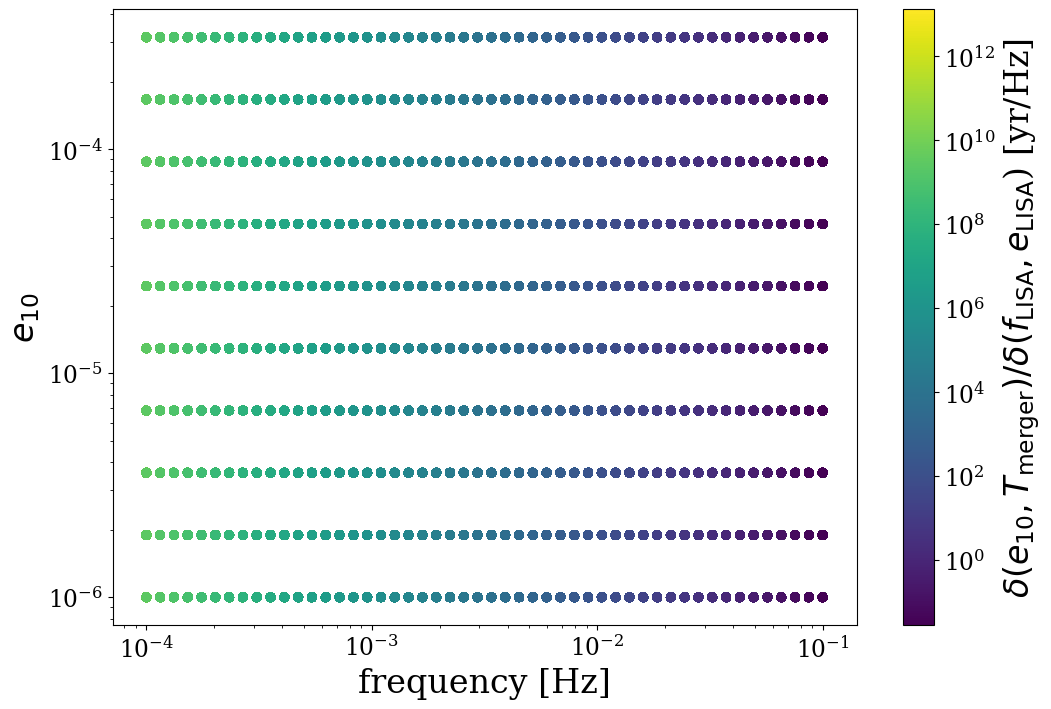

In [46]:
from matplotlib import colors
plt.scatter(FF, EE_LIGO, c=jacobian.value, norm=colors.LogNorm())
plt.colorbar(label=r'$\delta(e_{10},T_{\rm{merger}})/\delta(f_{\rm{LISA}}, e_{\rm{LISA}}$) [yr/Hz]')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('frequency [Hz]')
plt.ylabel(r'$e_{10}$')

Text(0, 0.5, '$e_{10}$')

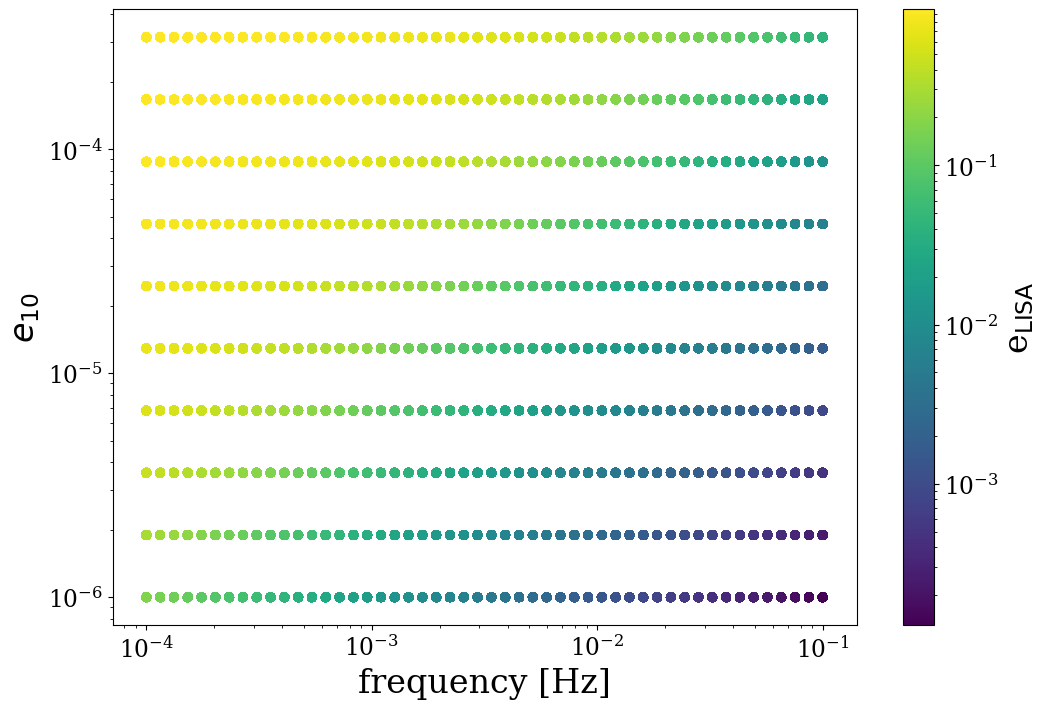

In [47]:
from matplotlib import colors
plt.scatter(FF, EE_LIGO, c=EE_LISA, norm=colors.LogNorm())
plt.colorbar(label=r'e$_{\rm{LISA}}$')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('frequency [Hz]')
plt.ylabel(r'$e_{10}$')

In [48]:
def get_jacobian(m1, m2, e_LIGO, f_LISA):
    EE_LIGO, FF = np.meshgrid(e_LIGO, f_LISA, indexing='ij')
    
    dat_size=EE_LIGO.shape
    dat_in = list(zip(EE_LIGO.flatten(), FF.flatten(), m1 * np.ones(dat_size), m2 * np.ones(dat_size)))
    with MultiPool(processes=96) as pool:
        dat_out = list(pool.imap(get_e_LISA_t_LIGO, dat_in))
        
    EE_LISA, TT_LIGO = zip(*dat_out)

    EE_LISA = np.array(EE_LISA).reshape(FF.shape)
    TT_LIGO = np.array(TT_LIGO).reshape(FF.shape) * u.yr
    
    
    de_LIGO_de_LISA = np.zeros(FF.shape)
    de_LIGO_df_LISA = np.zeros(FF.shape)
    for ff, forb in enumerate(f_LISA):
        de_LIGO_de_LISA[:,ff] = get_de_LIGO_de_LISA(e_LIGO_at_f_LISA=EE_LIGO[:,ff], e_LISA=EE_LISA[:,ff])
    for ee, ecc in enumerate(e_LIGO):
        de_LIGO_df_LISA[ee, :] = get_de_LIGO_df_LISA(e_LIGO_at_e_LISA=EE_LIGO[ee,:], f_LISA=f_LISA)
        
    de_LIGO_df_LISA = de_LIGO_df_LISA / u.Hz
    
    dT_LIGO_de_LISA = np.zeros(FF.shape)
    for ff, forb in enumerate(f_LISA):
        dT_LIGO_de_LISA[:,ff] = get_dT_LIGO_de_LISA(T_LIGO_at_f_LISA=TT_LIGO[:,ff], e_LISA=EE_LISA[:,ff])
        
    dT_LIGO_df_LISA = dTmerger_df(m1, m2, FF, EE_LIGO).to(u.yr / u.Hz)
    dT_LIGO_de_LISA = dT_LIGO_de_LISA * u.yr
    
    jacobian = dT_LIGO_de_LISA * de_LIGO_df_LISA - dT_LIGO_df_LISA*de_LIGO_de_LISA

    return jacobian

In [49]:
#down_samp_fac=100
#e_LIGO = np.logspace(-8,-4,5)
#f_LISA = np.logspace(-1, -5, 10)*u.Hz
#mass_1, mass_ratio, M1, Q, dN_dm1dqdVcdt = get_LIGO_rate(down_samp_fac=down_samp_fac)
#
#MM, QQ, EE, FF = np.meshgrid(mass_1, mass_ratio, e_LIGO, f_LISA, indexing='ij')
#
#print(np.shape(MM))
#JACOBIAN = np.zeros(MM.shape)
#
#for ii, m1 in tqdm.tqdm(enumerate(mass_1), total=len(mass_1)):
#    for qq, q in enumerate(mass_ratio):
#        JACOBIAN[ii,qq,:,:] = get_jacobian(m1=m1, m2=m1*q, e_LIGO=e_LIGO, f_LISA=f_LISA)

In [50]:
#JACOBIAN = JACOBIAN * u.yr / u.Hz

In [51]:
def get_horizon(m1, m2, e, f_orb, snr_thresh=12):
    source = lw.source.Source(m_1=m1,
                              m_2=m2,
                              ecc=e,
                              f_orb=f_orb,
                              dist=8 * u.Mpc,
                              interpolate_g=False,
                              gw_lum_tol=0.00001)

    snr = source.get_snr(approximate_R=True, verbose=False, t_obs=6*u.yr)

    d_horizon = snr / snr_thresh * 8 * u.Mpc

    return d_horizon


def get_Vc_Dh(dat_in):
    m1, q, e, f, snr_thresh = dat_in
    m_1 = m1
    m_2 = m1 * q
    d_h = get_horizon(m_1, m_2, e, f, snr_thresh)
    #Calculate the comoving volume based on the horizon distance + cosmology if necessary
    if d_h > 10*u.kpc:
        redshift = z_at_value(Planck18.luminosity_distance, d_h)
        V_c = Planck18.comoving_volume(z=redshift)
    else:
        V_c = 4/3 * np.pi * d_h**3  

    return [d_h.to(u.Gpc).value, V_c.to(u.Gpc**3).value]


In [52]:
snr_thresh = 12
dat_in = list(zip(MM.flatten(), QQ.flatten(), EE_LISA.flatten(), FF.flatten(), snr_thresh * np.ones(len(MM.flatten()))))
with MultiPool(processes=118) as pool:
    dat_out = list(tqdm.tqdm(pool.imap(get_Vc_Dh, dat_in), total=len(dat_in)))

100%|██████████| 100000/100000 [05:22<00:00, 309.81it/s]


In [53]:
DH, VC = zip(*dat_out)

DH = np.array(DH).reshape(QQ.shape) * u.Gpc
VC = np.array(VC).reshape(QQ.shape) * u.Gpc**3

np.shape(VC), np.shape(jacobian)

((20, 10, 10, 50), (20, 10, 10, 50))

In [54]:
LISA_norm = jacobian * VC
#print(jacobian.to(u.s / u.Hz))


In [55]:
import cmasher as cmr
colors = cmr.take_cmap_colors('cmr.guppy', len(e_LIGO), cmap_range=(0.05, 0.9), return_fmt='hex')
e_LIGO_round = np.array([f"{e:.2e}" for e in e_LIGO])


In [56]:
for ee, ecc in enumerate(e_LIGO):
    arg = (LISA_norm[:,:,ee,:]*dN_dm1dqdVcdt[5,5]*mass_1[5]*mass_ratio[]).to(u.Hz**(-1))
    #print(arg)
    N_LISA = cumulative_trapezoid(arg[0][0], -f_LISA, initial=0)
    plt.plot(f_LISA, N_LISA, c=colors[ee], label=f'eLIGO={e_LIGO_round[ee]}')
    
def get_horizon_and_chirp(dat_in):
    m1, m2, f = dat_in
    m2 = m1 * q
    mc = lw.utils.chirp_mass(m1, m2)

    s = lw.source.Source(m_1=m1,
                         m_2=m2,
                         ecc=0,
                         f_orb=f,
                         dist=8*u.Mpc,
                         interpolate_g=False)
    
    
    snr = s.get_snr(t_obs = 6 * u.yr, approximate_R=True, verbose=False)
    SNR_resolve = 12
    d_h = snr / SNR_resolve * 8 * u.Mpc
    
    V_h = 4/3 * np.pi * d_h**3
    if d_h > 100 * u.kpc:
        redshift= z_at_value(Planck18.luminosity_distance, d_h)
        V_h = Planck18.comoving_volume(z=redshift)

    f_dot = lw.utils.fn_dot(m_c=mc, e=0, n=1, f_orb=f)
    
    return d_h.to(u.Gpc).value, V_h.to(u.Gpc**3).value, f_dot.to(u.Hz/u.s).value


# set up the LISA frequency grid
f_LISA = np.logspace(-1, -5, 50) * u.Hz

# set up the LIGO eccentricity range
e_LIGO_circ = np.array([0])


# get the mass, mass ratio, and rate grids
mass_1, mass_ratio, M1, Q, dN_dm1dqdVcdt = get_LIGO_rate(down_samp_fac=down_samp_fac)

mass_1 = mass_1[5:6]
mass_ratio = mass_ratio[5:6]


MM, QQ, EE_LIGO, FF = np.meshgrid(mass_1, mass_ratio, e_LIGO_circ, f_LISA, indexing='ij')


# run on 98 processors
nproc=96

# loop over the mass and mass ratio grid to get the horizon distance
dat_in = []
for m1, q, f in zip(MM.flatten(), QQ.flatten(), FF.flatten()):
    dat_in.append([m1, q, f])
        
with MultiPool(processes=nproc) as pool:
    dat_out = list(tqdm.tqdm(pool.imap(get_horizon_and_chirp, dat_in), total=len(dat_in)))

D_H = []
V_H = []
F_DOT = []
for d in dat_out:
    d_h, V_h, f_dot = d
    D_H.append(d_h)
    V_H.append(V_h)
    F_DOT.append(f_dot)
F_DOT = np.array(F_DOT).flatten()*u.Hz / u.s
V_H = np.array(V_H).flatten()*u.Gpc**3

arg = (dN_dm1dqdVcdt[5,5]*mass_1*mass_ratio/F_DOT * V_H).to(u.Hz**(-1))

# get the rates
N_LISA = cumulative_trapezoid(arg, -f_LISA, initial=0)
plt.plot(f_LISA, N_LISA, c='black', label='e=0')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
 
plt.xlabel('f [Hz]')
plt.ylabel(r'$N_{LISA}$')
plt.xscale('log')
plt.yscale('log')
plt.legend(prop={'size':12}, ncol=5, loc=[0.0, 1.01])

ValueError: operands could not be broadcast together with shapes (20,10,50) (20,) 

100%|██████████| 50/50 [00:00<00:00, 340.06it/s]


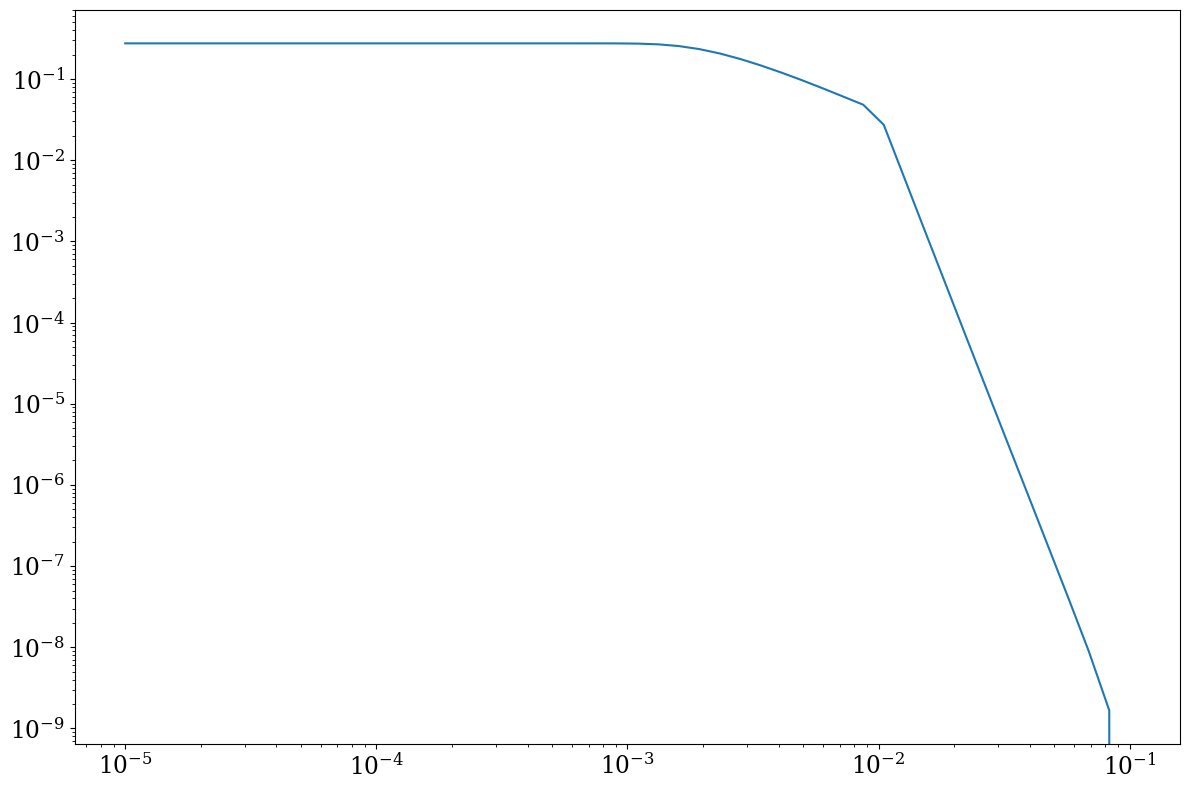

In [202]:
def get_horizon_and_chirp(dat_in):
    m1, m2, f = dat_in
    m2 = m1 * q
    mc = lw.utils.chirp_mass(m1, m2)

    s = lw.source.Source(m_1=m1,
                         m_2=m2,
                         ecc=0,
                         f_orb=f,
                         dist=8* u.Mpc,
                         interpolate_g=False)
    
    
    snr = s.get_snr(t_obs = 6 * u.yr, approximate_R=True, verbose=False)
    SNR_resolve = 12
    d_h = snr / SNR_resolve * 8 * u.Mpc
    
    V_h = 4/3 * np.pi * d_h**3
    if d_h > 100 * u.kpc:
        redshift= z_at_value(Planck18.luminosity_distance, d_h)
        V_h = Planck18.comoving_volume(z=redshift)

    f_dot = lw.utils.fn_dot(m_c=mc, e=0, n=1, f_orb=f)
    
    return d_h.to(u.Gpc).value, V_h.to(u.Gpc**3).value, f_dot.to(u.Hz/u.s).value


# set up the LISA frequency grid
f_LISA = np.logspace(-1, -5, 50) * u.Hz

# set up the LIGO eccentricity range
e_LIGO = np.array([0])


# get the mass, mass ratio, and rate grids
mass_1, mass_ratio, M1, Q, dN_dm1dqdVcdt = get_LIGO_rate(down_samp_fac=down_samp_fac)

mass_1 = mass_1[5:6]
mass_ratio = mass_ratio[5:6]


MM, QQ, EE_LIGO, FF = np.meshgrid(mass_1, mass_ratio, e_LIGO, f_LISA, indexing='ij')


# run on 98 processors
nproc=96

# loop over the mass and mass ratio grid to get the horizon distance
dat_in = []
for m1, q, f in zip(MM.flatten(), QQ.flatten(), FF.flatten()):
    dat_in.append([m1, q, f])
        
with MultiPool(processes=nproc) as pool:
    dat_out = list(tqdm.tqdm(pool.imap(get_horizon_and_chirp, dat_in), total=len(dat_in)))

D_H = []
V_H = []
F_DOT = []
for d in dat_out:
    d_h, V_h, f_dot = d
    D_H.append(d_h)
    V_H.append(V_h)
    F_DOT.append(f_dot)
F_DOT = np.array(F_DOT).flatten()*u.Hz / u.s
V_H = np.array(V_H).flatten()*u.Gpc**3

arg = (dN_dm1dqdVcdt[5,5]*mass_1*mass_ratio/F_DOT * V_H).to(u.Hz**(-1))
# get the rates
N_LISA = cumulative_trapezoid(arg, -f_LISA, initial=0)
plt.plot(f_LISA, N_LISA)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
 

In [37]:
dN_dm1dqde = np.zeros((len(mass_1),len(mass_ratio),len(e_LIGO))) * u.Gpc**3 * u.yr
for ii, m1 in tqdm.tqdm(enumerate(mass_1), total=len(mass_1)):
    for qq, q in enumerate(mass_ratio):
        for ee, e in enumerate(e_LIGO):
            dN_dm1dqde[ii,qq,ee] = trapezoid(LISA_norm[ii,qq,ee,:], -f_LISA)

100%|██████████| 1/1 [00:00<00:00, 4036.87it/s]


In [38]:
rate_e = []
for ee, e in enumerate(e_LIGO):
    dN_dm1dq = dN_dm1dqde[:,:,ee]
    dN_dm = trapezoid(dN_dm1dq * dN_dm1dqdVcdt.T, mass_ratio)
    N = trapezoid(dN_dm, mass_1)
    rate_e.append(N)

ValueError: operands could not be broadcast together with shapes (1,0) (20,9) 

In [ ]:
plt.plot(e_LIGO, rate_e)
plt.xscale('log')
plt.yscale('log')

In [ ]:
plt.scatter(FF.flatten()[ind], EE.flatten()[ind])
plt.xscale('log')

In [ ]:
plt.scatter(FF.flatten(), EE.flatten(), c=np.abs(jacobian.value), norm=colors.LogNorm(), s=5, marker='s')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

In [ ]:
plt.scatter(FF.flatten(), EE.flatten(), c=EE_LIGO.flatten(), norm=colors.LogNorm())
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

In [ ]:
for ii in range(0,len(f_LISA),20):
    plt.plot(e_LISA[:499], jacobian[ii,:499], label=f'log f={np.round(np.log10(f_LISA[ii].to(u.Hz).value), 2)}')
plt.xscale('log')
plt.yscale('log')
plt.legend(ncol=3, prop={'size':15}, loc=[0.0, 1.01])
plt.ylabel('jacobian at different frequencies')
plt.xlabel('eccentricity')

In [ ]:
for ii in range(0,len(e_LISA),50):
    plt.plot(f_LISA[:99], jacobian[:99,ii], label=f'log e={np.round(np.log10(e_LISA[ii]), 2)}')
plt.xscale('log')
plt.yscale('log')
plt.legend(ncol=3, prop={'size':15}, loc=[0.0, 1.01])
plt.ylabel('jacobian at different eccentricities')
plt.xlabel('frequency')

In [ ]:
def get_horizon(m1, m2, e, f_orb):
    source = lw.source.Source(m_1=m1,
                              m_2=m2,
                              ecc=e,
                              f_orb=f_orb,
                              dist=8 * u.Mpc,
                              interpolate_g=False,
                              gw_lum_tol=0.00001)

    #source.evolve_sources(t_evol=4 * u.yr)
    snr = source.get_snr(approximate_R=True, verbose=False)

    snr_thresh = 12.0
    d_horizon = snr / snr_thresh * 8 * u.Mpc

    return d_horizon


def get_Vc_Dh(dat_in):
    m1, m2, e, f = dat_in
    m_1 = m1
    m_2 = m1
    d_h = get_horizon(m_1, m_2, e, f)
    #Calculate the comoving volume based on the horizon distance + cosmology if necessary
    if d_h > 10*u.kpc:
        redshift = z_at_value(Planck18.luminosity_distance, d_h)
        V_c = Planck18.comoving_volume(z=redshift)
    else:
        V_c = 4/3 * np.pi * d_h**3  

    return [d_h, V_c]

dat_in = []
for ee, ff in zip(EE.flatten(), FF.flatten()):
    dat_in.append([m1, m2, ee, ff])


In [ ]:
with MultiPool(processes=60) as pool:
    dat_out = list(tqdm.tqdm(pool.imap(get_Vc_Dh, dat_in), total=len(dat_in)))

In [ ]:
d_h = []
V_c = []

for d in dat_out:
    d_h.append(d[0])
    V_c.append(d[1])
    
d_h = np.vstack(d_h).flatten()
V_c = np.vstack(V_c).flatten()

ind0, = np.where(d_h == 0)
len(ind0)

In [ ]:
LIGO_rate = 32 * u.yr / u.Gpc**3

In [ ]:
np.shape(jacobian)

In [ ]:
f_LISA

In [ ]:
np.max(cumulative_trapezoid(jacobian * LIGO_rate * V_c.reshape(np.shape(jacobian)).to(u.Gpc**3), -f_LISA_grid, axis=0, initial=0))

In [ ]:
V_c = V_c.reshape(np.shape(jacobian)).to(u.Gpc**3)

In [ ]:
np.shape(jacobian[0,:]), np.shape(V_c[0,:])

In [ ]:
(jacobian[0,:]*LIGO_rate*V_c[0,:])

In [ ]:
f_LISA

In [ ]:
plt.plot(f_LISA, cumulative_trapezoid(jacobian[:,0] * LIGO_rate * V_c[:,0], -f_LISA, initial=0))
plt.xscale('log')
plt.yscale('log')

In [ ]:
for ii in range(0, len(e_LISA), 20):
    print(ii)
    plt.plot(f_LISA, d_h.reshape(np.shape(EE))[:,ii])
    
plt.yscale('log')
plt.xscale('log')

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
dNdfdMcdVc = 1 * jacobian
p1 = ax1.scatter(FF.flatten().value, EE.flatten(), c=V_c.flatten().to(u.Mpc**3).value, norm=colors.LogNorm(), s=5)
c1 = plt.colorbar(p1)
c1.set_label(label=r'horizon $V_c$ [Gpc$^3$]', size=14)
p2 = ax2.scatter(FF.flatten().value, EE.flatten(), c=jacobian.flatten().value, norm=colors.LogNorm(), s=5)
c2 = plt.colorbar(p2)
c2.set_label(label='jacobian', size=14)
p3 = ax3.scatter(FF.flatten().value, EE.flatten(), c=cumulative_trapezoid(jacobian * LIGO_rate * V_c.reshape(np.shape(jacobian)).to(u.Gpc**3), np.flip(f_LISA_grid), axis=0, initial=0), norm=colors.LogNorm(), s=5)
c3 = plt.colorbar(p3)
c3.set_label(label='cumulative rate at f', size=14)
# !!!! check the slope for increasing eccentricity
    
ax1.set_xscale('log')
ax2.set_xscale('log')
ax3.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')

ax1.set_ylabel('eccentricity', size=14)
ax2.set_ylabel('eccentricity', size=14)
ax3.set_ylabel('eccentricity', size=14)
ax1.set_xlabel('frequency [Hz]', size=14)
ax2.set_xlabel('frequency [Hz]', size=14)
ax3.set_xlabel('frequency [Hz]', size=14)
plt.tight_layout()



In [ ]:
f_mask =(f_LISA_grid>0.025*u.Hz) & (f_LISA_grid < 0.045 * u.Hz)
print(d_horizon[f_mask])
print(t_merge_LISA_grid[f_mask].to(u.yr))
#print(e_LISA_grid[f_mask])
print(snr[f_mask])
print(e_LIGO, trapz(dNdfdMc, -f_LISA_grid))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import legwork as lw
import astropy.units as u
from scipy.interpolate import interp1d
from astropy.cosmology import Planck18, z_at_value
from scipy.integrate import trapz
import paths
import tqdm

def ligo_rate(m1):
    dat = np.array([[3.705799151343708, 0.001087789470121345],
                   [4.384724186704389, 0.00984816875074369],
                   [5.063649222065067, 0.06979974252228799],
                   [5.827439886845831, 0.41173514594201527],
                   [6.506364922206512, 1.3579705933006465],
                   [6.845827439886847, 2.148948034692836],
                   [7.77934936350778, 2.7449738151212433],
                   [8.543140028288544, 2.6218307403757986],
                   [9.561527581329564, 2.0525434471508692],
                   [11.173974540311175, 1.2388629239937763],
                   [12.701555869872706, 0.7828664968878465],
                   [14.398868458274404, 0.4947116747780942],
                   [16.859971711456865, 0.2895969742197884],
                   [19.66053748231967, 0.17748817964452962],
                   [22.206506364922213, 0.12773570001722281],
                   [24.837340876944843, 0.10389898279212807],
                   [27.722772277227726, 0.1087789470121345],
                   [30.183875530410184, 0.13070104796093673],
                   [32.729844413012735, 0.16441704701060267],
                   [34.85148514851486, 0.16695189854274867],
                   [37.397454031117405, 0.12107555776371784],
                   [39.26449787835927, 0.08010405199404155],
                   [41.30127298444131, 0.049851062445855264],
                   [43.592644978783596, 0.029631988560550687],
                   [45.629420084865636, 0.018440841322693136],
                   [48.0905233380481, 0.011832859313068754],
                   [50.891089108910904, 0.007949361111716631],
                   [53.77652050919379, 0.005764973856945108],
                   [57.25601131541727, 0.0043438393396653925],
                   [61.923620933521946, 0.0032730313574784275],
                   [66.67609618104669, 0.0024851284269805634],
                   [70.66478076379069, 0.002068305171949823],
                   [74.82319660537483, 0.0016952583040389245],
                   [78.72701555869875, 0.0013476220436441713],
                   [81.27298444130128, 0.0010389898279212807]])
    
    mass = dat[:,0]
    rate = dat[:,1]
    interp_rate = interp1d(mass, rate)
    
    return interp_rate(m1)

# set up the grids
masses = np.arange(5, 80, 5.0)
m_c = lw.utils.chirp_mass(masses, masses)

# set up bins
delta_m = np.mean(masses[1:] - masses[:-1])/2
mass_bins = np.arange(min(masses) - delta_m, max(masses) + 3 * delta_m, 2*delta_m)
masses = masses * u.Msun
mass_bins = mass_bins * u.Msun
#ecc_bins = [5e-5, 4e-5, 3e-5, 2e-5, 1e-5, 1e-6, 1e-7,1e-8, 0.0]
#ecc_bins = [1e-10]
ecc_bins = np.logspace(-4.2, -9, 10)

## get the meshgrid
#MASS, ECC = np.meshgrid(masses, ecc_bins)
#MC = lw.utils.chirp_mass(MASS, MASS)
#RATE = ligo_rate(MASS.flatten().value)
#RATE = RATE.reshape(MC.shape) * u.Gpc**(-3) * u.yr**(-1) * u.Msun**(-1)
snr_thresh = 7
dNdMc_ecc_2 = []
for e_LIGO in ecc_bins:
    dNdMc = []
    RATE = ligo_rate(masses) * u.Gpc**(-3) * u.hr**(-1) * u.Msun**(-1)
    for m1, m2, LR in zip(masses, masses, RATE):
        a_LIGO = lw.utils.get_a_from_f_orb(m_1=m1, m_2=m2, f_orb = 10 * u.Hz)
        dat_out = get_LISA_params(m1, m2, e_LIGO, a_LIGO)
        #f_LISA_grid*u.Hz, e_LISA_grid, t_merge_LISA_grid, f_dot_orb_LISA_grid, t_evol
        f_LISA_grid, e_LISA_grid, t_merge_LISA_grid, f_dot_orb_LISA_grid, t_evol = dat_out
        print(np.max(e_LISA_grid))
        s = source = lw.source.Source(m_1=m1*np.ones(len(e_LISA_grid)),
                                      m_2=m2*np.ones(len(e_LISA_grid)),
                                      ecc=e_LISA_grid,
                                      f_orb=f_LISA_grid,
                                      dist=8 * np.ones(len(e_LISA_grid)) * u.Mpc,
                                      interpolate_g=False)
        snr = s.get_snr()
        d_horizon = np.ones(len(e_LISA_grid))* 8 * u.Mpc * snr/snr_thresh
        horizon_mask = d_horizon > 0.001 * u.Mpc
        horizon_comoving_volume = 4/3 * np.pi * d_horizon**3
        redshift = np.zeros(len(e_LISA_grid))
        redshift[horizon_mask] = z_at_value(Planck18.luminosity_distance, d_horizon[horizon_mask])
        horizon_comoving_volume[horizon_mask] = Planck18.comoving_volume(z=redshift[horizon_mask])
        f_dot_orb_LISA_grid = lw.utils.fn_dot(m_c = lw.utils.chirp_mass(m1, m2), e=e_LISA_grid, n=1, f_orb=f_LISA_grid)
        dNdMc.append(trapz(LR / f_dot_orb_LISA_grid * horizon_comoving_volume.to(u.Gpc**3), -f_LISA_grid).value)
    dNdMc_ecc_2.append(dNdMc)
dNdMc = np.array(dNdMc_ecc_2[0])
        
N_LISA_obs=trapz(dNdMc * u.Msun**(-1), masses)
print(N_LISA_obs)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(masses, dNdMc, lw=3, label=r"LISA")
ax.set_yscale('log')
#ax.plot(masses, ligo_rate(masses)/45, lw=2, label=r"LIGO")
plt.legend(prop={"size":14})
plt.tick_params('both', labelsize=12)
plt.minorticks_on()
ax.set_xlabel('mass [Msun]', size=16)
ax.set_ylabel('p(M) [M$_{\odot}^{-1}$]', size=16)
plt.tight_layout()
plt.savefig(paths.figures / 'fig1.png', facecolor='white', dpi=100)


In [ ]:
N_LISA_obs = []
for ii in range(len(ecc_bins)):
    dNdMc = np.array(dNdMc_ecc_2[ii])
    plt.plot(masses, dNdMc, label=np.round(ecc_bins[ii], 10), lw=10-ii)
    N_LISA_obs.append(trapz(dNdMc * u.Msun**(-1), masses))

    print(ecc_bins[ii], N_LISA_obs)
plt.yscale('log')
plt.legend()

In [ ]:
plt.plot(ecc_bins, N_LISA_obs)
plt.scatter(ecc_bins, N_LISA_obs)
plt.xscale('log')